# Latent Dirichlet Allocation

In this final assignment, you will implement LDA and try it out on a corpus. Be sure to start work on this assignment early, because running your code will take some time. A full run of my implementation took about four hours. Consider running your code on smaller subcorpora during debugging.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import warnings
warnings.filterwarnings('ignore')

## Data loading

Try your Gibbs sampler on the corpus of 2000 movie reviews from Pang & Lee (2004), available on Classroom. The first line of the file specifies the number of documents. Then each subsequent line is one document, with the tokens separated by whitespace. I generated the file on Classroom from the original movie reviews by tokenizing them and then removing punctuation and stopwords, so you get nicer topics.

In [4]:
# please restart runtime to get NumPy library updated
! pip install pyLDAvis
! pip install wget

You should consider upgrading via the '/Users/tsimafeip/pythonProject/venv_m1/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/tsimafeip/pythonProject/venv_m1/bin/python -m pip install --upgrade pip' command.


In [5]:
FORCE_RETRAIN_MODEL = True
PATH_TO_TRAINED_MODEL = '20_topics_500_iters_full_vocab.json'

NUM_OF_TOPICS = 20
NUM_OF_ITERATIONS = 300
# -1 is default for saving only after full train
SAVE_EVERY_N_ITERATIONS = 50

SOURCE_DATA_FILENAME = 'preprocessed_docs.txt'

In [6]:
import os
import wget
import pyLDAvis

/users/tsimafeip/pythonProject/venv_m1/lib/python3.8/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/users/tsimafeip/pythonProject/venv_m1/lib/python3.8/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
/users/tsimafeip/pythonProject/venv_m1/lib/python3.8/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe1` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1


In [8]:
from lda_solution import DataHelper

data_helper = DataHelper(SOURCE_DATA_FILENAME, NUM_OF_TOPICS)

print(data_helper.NUM_OF_DOCS, data_helper.VOCAB_SIZE, data_helper.CORPUS_SIZE)

19334 111787 4773600


In [10]:
# I wanted to check topic distribution prior to all training
# We can see that it is almost uniform
sb_vis_data = data_helper.get_lda_vis_data()
pyLDAvis.display(sb_vis_data)

## Gibbs sampler

Implement a Gibbs sampler which resamples a topic for each word in the corpus according to the probability distribution in formula [5] of [Griffiths & Steyvers (2004)](https://www.pnas.org/content/101/suppl_1/5228). Initialize the topic assignments by choosing a topic uniformly at random for each token in the corpus. You can also refer to [Darling tutorial](https://u.cs.biu.ac.il/~89-680/darling-lda.pdf) for details of implementation.

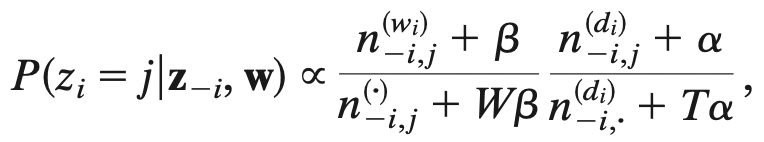

[238659, 238270, 238921, 238743, 239173, 238697, 238119, 238162, 238153, 238364, 238747, 238421, 238580, 239276, 238740, 238997, 239018, 238882, 239244, 238434]


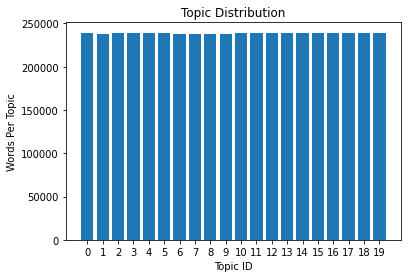

In [12]:
from lda_solution import plot_topic_distribution

print(data_helper.topic_counter)
plot_topic_distribution(data_helper.topic_counter)

Algorithm
```
        run for NUM_OF_ITERATIONS (hyperparam)
            for each word_document pair in corpus
                get current topic
                decrease all respective counts:
                    - general count of this topic;
                    - count of this topic for specific word;
                    - count of this topic in document;
                run loop over topics count K
                    re-evaluate word_to_topic sampling probabilites
                choose new topic for the word based on weights obtained above
                increase all respective counts
```

Apply Gibbs sample to full corpus:

In [13]:
from lda_solution import GibbsSampler

if FORCE_RETRAIN_MODEL:
    gibbs_sampler = GibbsSampler(data_helper)
    data_helper = gibbs_sampler.train(NUM_OF_ITERATIONS, iterations_to_save=SAVE_EVERY_N_ITERATIONS)
    path_to_trained_helper = data_helper.export_trained_helper()
else:
    data_helper = DataHelper.import_trained_helper(
        path_to_model_file=PATH_TO_TRAINED_MODEL,
        base_data_helper=data_helper,
    )
    data_helper.run_consistency_tests()

 12%|█▏        | 58/500 [1:39:52<12:41:11, 103.33s/it]

[8451, 7055, 12556, 8046, 9490, 229583, 40165, 18946, 8410, 11954, 8364, 11309, 6911, 10302, 8554, 13146, 8624, 11309, 7343, 258266]


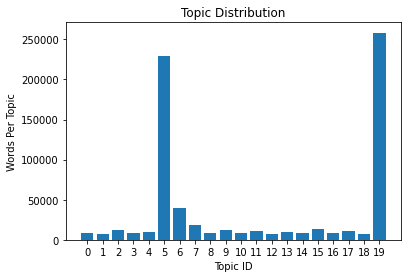

In [ ]:
# distribution after training
print(data_helper.topic_counter)
plot_topic_distribution(data_helper.topic_counter)

Even after filtering out very common words and 500 iterations I had almost the same top-10 topic wordlists. Hence, we need some advanced to analyse topic distinction. I have decided to use [pyLDAvis](!https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) and set $\lambda$ (relevance metric parameter) to 0.2 to check unique words for each topic. Also, PCA plot helps to understand whether we learned some different topics or not.

In [ ]:
movies_vis_data = data_helper.get_lda_vis_data()
pyLDAvis.display(movies_vis_data)

In [ ]:
def load_model_and_get_vis_data(model_name: str):
    """Loads model from json file and runs pyLDAvis."""
    if FORCE_RETRAIN_MODEL is False and not os.path.isfile(model_name):
        wget.download(f'{path_to_git_folder}/models/{model_name}')

    loaded_data_helper = DataHelper.import_trained_helper(
        path_to_model_file=model_name,
        path_to_source_data=SOURCE_DATA_FILENAME,
    )
    loaded_data_helper.run_consistency_tests()

    print(loaded_data_helper.NUM_OF_DOCS, loaded_data_helper.VOCAB_SIZE, loaded_data_helper.CORPUS_SIZE)
    return loaded_data_helper.get_lda_vis_data()

In [ ]:
# Visualise model after 100 iterations
vis_data = load_model_and_get_vis_data('20_topics_100_iters_full_vocab.json')
pyLDAvis.display(vis_data)

2000 46517 698784


In [ ]:
# Visualise model after 400 iterations
vis_data = load_model_and_get_vis_data('20_topics_300_iters_full_vocab.json')
pyLDAvis.display(vis_data)

2000 46517 698784


## Extra credit

- Use Numpy to speed up the calculations;
- try your system on other corpora; 
- experiment with different strategies for initializing the topic assignments (e.g., give the same topic to all words of the same document);
- use a bit of supervised information (e.g., fix the topic assignments for specific words that you know should belong to that topic, and do not allow the sampler to change them).


Uncomment code below if you want to recreate Belarusian/Russian files with more/less documents.
Please be careful, since big (~110mb) source files will be downloaded here.

In [ ]:
# ! pip install gsutil

# raw_bel_filepath = "Corpus_Bel.txt_tok.txt_true.txt"
# raw_rus_filepath = "Corpus_Rus.txt_tok.txt_true.txt"

# if not os.path.isfile(raw_bel_filepath):
#     !gsutil -m cp -r "gs://mytranslator-298419-vcm/RuBeCorpus_BelapanNews/Separate Corpuses/FullCorpus/$raw_bel_filepath" .
    
# if not os.path.isfile(raw_rus_filepath):
#     !gsutil -m cp -r "gs://mytranslator-298419-vcm/RuBeCorpus_BelapanNews/Separate Corpuses/FullCorpus/$raw_rus_filepath" .

# def convert_corpus_to_lda_format(source_filepath: str, lang: str, size_of_corpus: int = 20000) -> str:
#     target_file_name = f'belapan_lda_{lang}.txt'
#     with open(source_filepath, 'r') as input_f, open(target_file_name, 'w') as output_f:
#         output_f.write(f"{size_of_corpus}\n")
#         for i, line in enumerate(input_f):
#             if i == size_of_corpus:
#                 break
#             output_f.write(line)
    
#     return target_file_name

# lda_bel_file = convert_corpus_to_lda_format(raw_bel_filepath, lang='be')
# lda_ru_file = convert_corpus_to_lda_format(raw_rus_filepath, lang='ru')

# print(lda_bel_file, lda_ru_file)

In [ ]:
BEL_SOURCE_FILENAME = 'belapan_lda_be.txt'
BEL_TRAINED_MODEL = '20_topics_500_iters_bel_model.json'

if not os.path.isfile(BEL_SOURCE_FILENAME):
    wget.download(f'{path_to_git_folder}/data/{BEL_SOURCE_FILENAME}')

if not os.path.isfile(BEL_TRAINED_MODEL):
    wget.download(f'{path_to_git_folder}/models/{BEL_TRAINED_MODEL}')

In [ ]:
bel_data_helper = DataHelper.import_trained_helper(
    path_to_model_file=BEL_TRAINED_MODEL,
    path_to_source_data=BEL_SOURCE_FILENAME,
)
bel_data_helper.run_consistency_tests()

print(bel_data_helper.NUM_OF_DOCS, bel_data_helper.VOCAB_SIZE, bel_data_helper.CORPUS_SIZE)
bel_vis_data = bel_data_helper.get_lda_vis_data()
pyLDAvis.display(bel_vis_data)

20000 44254 447300
